In [35]:
import numpy as np
import random
import sympy as sp
import numpy as np
import numpy.linalg as la

import control as pc

%matplotlib notebook
import matplotlib.pyplot as plt
plt.ioff()

plt.rcParams['figure.figsize'] = [10, 5]

In [36]:
''' function A = getA(s,w,p)
Creates symbolic A Matrix with given vectors of symbol names.
Creates ordered A, first complex poles, then real poles
   w: symbols of real parts of complex poles
   s: symbols of imaginary part of complex poles
   p: symbols of purely real poles
   
   A: sympy symbolical matrix
'''
def getA(s,w,p):
    if not isinstance(w, tuple):
        w = (w,)
    if not isinstance(s, tuple):
        s = (s,)
    if not isinstance(p, tuple):
        p = (p,)
    A = sp.zeros(len(2*w+p), len(2*w)+len(p))
    for i,(v,r) in enumerate(zip(w,s)):
        XX = sp.Matrix([[r, v],[-v,r]])
        ix = 2*i
        A[ix, ix] = r
        A[ix+1, ix+1] = r
        A[ix, ix+1] = v
        A[ix+1, ix] = -v
    for i,r in enumerate(p):
        A[len(2*w)+i, len(2*w)+i] = r
    return A

# Test getA
#wx = sp.symbols('w_1:3')
#sx = sp.symbols('s_1:3')
#px = sp.symbols('p_1:3')
#sp.pprint(getA(wx,sx,px))



''' function A, (ss, s_init), (ws, w_init), (ps, p_init) = getA2(init_arr)

Creates symbolic A Matrix and tuples of ( (symbolic names), [given values]),
with given numerical vector of (complex) poles.
Creates A with the order of the given poles, and return tupels
to map the numerical values to the respective symbolic name.
   init_arr: (numpy) array of numerical poles
   
   ws: symbols of real parts of complex poles
   w_init: numerical values of real parts of complex poles
   ss: symbols of imaginary parts of complex poles
   s_init: numerical values of imaginary parts of complex poles
   ps: symbols of real poles
   p_init: numerical values of real poles
'''
def getA2(init_arr):
    num_cplx_poles = 0
    num_real_poles = 0
    A = None
    w_init = []
    ws = []
    s_init = []
    ss = []
    p_init = []
    ps = []
    
    for val in init_arr:
        if np.iscomplex(val):
            if np.conjugate(val) in init_arr:
                print "Ignored additional complex conjugate pole: {}".format(np.conjugate(val))
                init_arr.remove(np.conjugate(val))
            num_cplx_poles = num_cplx_poles + 1
            w = sp.symbols('w_{}'.format(num_cplx_poles)) # creates tuple (w_1)
            s = sp.symbols('s_{}'.format(num_cplx_poles)) # creates tuple (s_1)
            X = sp.Matrix([[s, w],[-w,s]])
            s_init.append(val.real)
            ss.append(s)
            w_init.append(val.imag)
            ws.append(w)
        else:
            num_real_poles = num_real_poles + 1
            p = sp.symbols('p_{}'.format(num_real_poles))
            X = sp.Matrix([p])
            p_init.append(val)
            ps.append(p)
        if A is None:
            A = X
        else:
            if not A:
                A = X
            else:
                A = A.row_insert(A.shape[0], sp.zeros(X.shape[0], A.shape[1]))
                A = A.col_insert(A.shape[1], sp.zeros(A.shape[1], X.shape[0]).row_insert(A.shape[0], X))
    return A, (tuple(ss), s_init), (tuple(ws), w_init), (tuple(ps), p_init)


# Test getA2()
#A, (ss, s_init), (ws, w_init), (ps, p_init) = getA2([-1, 2+3j, -2])
#sp.pprint(A)
#print ss, s_init
#print ws, w_init
#print ps, p_init

In [37]:
## Helper functions

''' Create sympy vector from symbols tuple
'''
def to_sympy_vector(syms):
    return sp.Matrix(syms)
#sp.pprint(to_sympy_vector(sp.symbols('w_1:5')))



''' Lookup of numerical value from 'values' by mapping 'syms' on 'all_syms'
     -> Slower than 'get_accessor' function
'''
def get_value_by_symbol(values, all_syms, syms):
    res = []
    for sy in syms:
        idx = list(all_syms).index(sy)
        res.append(values[idx])
    return np.matrix(np.array(res).squeeze())

# Test 
#wx = sp.symbols('w_1:3')
#sx = sp.symbols('s_1:3')
#assert(np.all(get_value_by_symbol(np.arange(len(sx+wx)), sx+wx, sx) == np.arange(len(sx))))


''' Creates lamdified function to lookup 'syms' in a vector structured like 'all_syms'
     -> Faster than 'get_value_by_symbol', yet less general (error prone if structure changes)
'''
def get_accessor(all_syms_vector, syms):
    return sp.lambdify(all_syms_vector, syms)


In [38]:
'''
Unroll for np.matrix instead of np.array
'''
def _c(M):
    sh = M.shape
    if sh[0] == 1:
        return M.tolist()[0]
    elif sh[1] == 1:
        return M.T.tolist()[0]
    else:
        print "WARNING! Unrolling can go horribly wrong with matrizes!"
        return M.ravel().tolist[0]

In [39]:
''' Define Indetification System model with initial values
System is characterized by number of poles given with numerical values
'''

### Define poles with initial vlues
num_poles = [-2+3j, -2]


A, (s, s_init), (w, w_init), (p, p_init) = getA2(num_poles)
num_cplx_poles = len(s_init)
num_real_poles = len(p_init)

# Define all symbolic names in sympy tuples
b = sp.symbols('b_1:{}'.format(2*num_cplx_poles+num_real_poles+1)) # creates tuple (b_1, b_2, b_3, b_4)
d = sp.symbols('d_1:2') # creates tuple (d_1)
x = sp.symbols('x_1:{}'.format(2*num_cplx_poles+num_real_poles+1)) # creates tuple (x_1, x_2, x_3, x_4)
c = sp.symbols('c_1:{}'.format(2*num_cplx_poles+num_real_poles+1)) # creates tuple (c_1, c_2, c_3, c_4)

u = sp.symbols('u_1:2')

# define structures / matrizes / vectors of symbols
X = to_sympy_vector(x)
U = to_sympy_vector(u)

B = to_sympy_vector(b)
C = to_sympy_vector(c).T
D = to_sympy_vector(d)

z = x+s+w+p+b+c+d # tuple of all symbols in Z (state vector)
Z = to_sympy_vector(z)

zu = z+u

fx = A*X+B*U # State space representation -> This changes over time (has dynamics)
f = sp.Matrix([0 for _ in range(len(z)-len(x))]) # -> All parameters do not have dynamics but shall remain the same (the correct estimate)
f = fx.col_join(f) # join together for full state transition vector
print "f="; sp.pprint(f)

F = f.jacobian(z) # First order derivitive of f
print "F="; sp.pprint(F)

h = C*X+D*U
print "h="; sp.pprint(h)

H = h.jacobian(z) # First order derivitive of h
print "H="; sp.pprint(H)



# Create (fast) numericial functions to get numerical matrices/vectors with given values
# ("paste values to the right positions")

AA = sp.lambdify(s+w+p, A)
BB = sp.lambdify(b, B)
CC = sp.lambdify(c, C)
DD = sp.lambdify(d, D)


ff = sp.lambdify(zu, f)
FF = sp.lambdify(zu, F)

hh = sp.lambdify(zu, h)
HH = sp.lambdify(zu, H)


f=
⎡b₁⋅u₁ + s₁⋅x₁ + w₁⋅x₂⎤
⎢                     ⎥
⎢b₂⋅u₁ + s₁⋅x₂ - w₁⋅x₁⎥
⎢                     ⎥
⎢    b₃⋅u₁ + p₁⋅x₃    ⎥
⎢                     ⎥
⎢          0          ⎥
⎢                     ⎥
⎢          0          ⎥
⎢                     ⎥
⎢          0          ⎥
⎢                     ⎥
⎢          0          ⎥
⎢                     ⎥
⎢          0          ⎥
⎢                     ⎥
⎢          0          ⎥
⎢                     ⎥
⎢          0          ⎥
⎢                     ⎥
⎢          0          ⎥
⎢                     ⎥
⎢          0          ⎥
⎢                     ⎥
⎣          0          ⎦
F=
⎡s₁   w₁  0   x₁  x₂   0   u₁  0   0   0  0  0  0⎤
⎢                                                ⎥
⎢-w₁  s₁  0   x₂  -x₁  0   0   u₁  0   0  0  0  0⎥
⎢                                                ⎥
⎢ 0   0   p₁  0    0   x₃  0   0   u₁  0  0  0  0⎥
⎢                                                ⎥
⎢ 0   0   0   0    0   0   0   0   0   0  0  0  0⎥
⎢                                    

In [40]:
# Define R and Q

R = 1
print "R:", R


rho = 0.1
# Some certainty for values not in x or c. 
# TODO: Read paper why...

q = np.array([])
for sym in z:
    if sym in X.T.row_join(C):
        q = np.hstack((q, 0))
    else:
        q = np.hstack((q, 1))

Q = rho * np.matrix(np.diag(q))
print "Q:\n", Q

R: 1
Q:
[[0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.1 0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.1 0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.1 0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.1 0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.1 0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.1 0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.1]]


In [41]:
'''
Initialize Testsystem
'''
import control as pc

class TestSystem:
    def __init__(self):

        Af = np.matrix([[  -2, 4],
                [  -4, -2]])

        Bf = np.matrix([[ 1],
                        [ 1]])

        Cf = np.matrix([[ 1/0.3, 0.]])

        Df = np.matrix([[ 0.]])

        self.T = 0.1

        ss2 = pc.ss(Af, Bf, Cf, Df)
        #plt.plot(*pc.step_response(ss2))

        # Time delay approx.
        numerator, denominator = pc.pade(self.T, 15)

        tf3 = pc.series(ss2, pc.tf(numerator,denominator))
        ss3 = pc.tf2ss(tf3)

        #plt.plot(*pc.step_response(ss3))
        #plt.show()

        #print pc.dcgain(ss2)
        #print ss2.pole()
        
        self.A = ss3.A
        self.B = ss3.B
        self.C = ss3.C
        self.D = ss3.D
        
        self.x0 = np.zeros((len(self.B),1))
        self.xt = self.x0
        

    def calc_TestSystem(self, u):

        print "u", u.shape
        u = np.matrix(u)
       
        x_dot = self.A.dot(self.xt) + self.B.dot(u)

        y = self.C.dot(self.xt) + self.D.dot(u)

        self.xt = self.xt + x_dot*self.T

        return y


sys = TestSystem()

In [42]:
import control as con

Af = np.matrix([[  -2, 4],
                [  -4, -2]])

Bf = np.matrix([[ 1],
                [ 1]])

Cf = np.matrix([[ 1/0.3, 0.]])

Df = np.matrix([[ 0.]])

Tf = 0.1

ss2 = con.ss(Af, Bf, Cf, Df)
#plt.plot(*con.step_response(ss2))
#plt.show()


numerator, denominator = con.pade(Tf, 15)

tf3 = con.series(ss2, con.tf(numerator,denominator))
ss3 = con.tf2ss(tf3)

#plt.plot(*con.step_response(ss3))
#plt.show()

Af = ss3.A
Bf = ss3.B
Cf = ss3.C
Df = ss3.D

print con.dcgain(ss2)
print ss2.pole()


### Testsystem ####
xx_0 = np.zeros((len(Bf),1))

x_t_real = xx_0
def calc_TestSystem(u):
    global Af, Bf, Cf, Df, x_t_real

    #print "Af:\n", Af
    #print "x_t:\n", x_t_real
    x_dot = Af.dot(x_t_real)
    x_dot = x_dot + Bf.dot(u)
    y = Cf.dot(x_t_real) + Df.dot(u)
    
    #print x_dot
    x_t_real = x_t_real + x_dot*T

    return y

1.0
[-2.+4.j -2.-4.j]


In [43]:
# return real part of a vector
def real_vector(vector):
    return map(lambda x: x.real, vector)

# return imaginary part of a vector
def imag_vector(vector):
    return map(lambda x: x.imag, vector)

In [44]:
# initial
random.seed(42) # Set the random number generator to a fixed sequence.

# Assign initial values to the poles
s_k0 = np.matrix(s_init)
w_k0 = np.matrix(w_init)
p_k0 = np.matrix(p_init)

# Assign random values to the state space system
b_k0 = np.matrix((np.random.rand(len(b))))
c_k0 = np.matrix((np.random.rand(len(c))))
d_k0 = np.matrix(np.zeros(len(d)))



# Initial P
P_k0 = np.eye(len(z))

# initial x0
x_k0 = np.matrix(np.zeros(len(x))).T

# first step height u, also mean step height for all steps
u_k0 = np.matrix([0.1])
# first step time
step_time = 0.1


# Sampling time
T = 0.001



# First values
x_k = x_k0
x_t = np.matrix([0, 0]).T
u_k = u_k0
z_k = np.hstack((x_k0.T, s_k0, w_k0, p_k0, b_k0, c_k0, d_k0)).T
P_k = P_k0


# naive Logging 
poles = []
y = []
y_e = []

u = []
nor0 = []
nor1 = []
nor2 = []
nor3 = []
nor4 = []



# Create accessors
x_from_z = get_accessor(Z, x)
s_from_z = get_accessor(Z, s)
w_from_z = get_accessor(Z, w)
p_from_z = get_accessor(Z, p)

swp_from_z = get_accessor(Z, s+w+p)

b_from_z = get_accessor(Z, b)
c_from_z = get_accessor(Z, c)
d_from_z = get_accessor(Z, d)

In [45]:
%%time
##########################################################
# Loop start
for cnt, t in enumerate(np.arange(T, 60, T)):

    ##### Reconstruction from z (current state of estimation)
    x_k = np.matrix(x_from_z(*_c(z_k))).T
    swp_k = np.matrix(swp_from_z(*_c(z_k)))
    b_k = np.matrix(b_from_z(*_c(z_k)))
    c_k = np.matrix(c_from_z(*_c(z_k)))
    d_k = np.matrix(d_from_z(*_c(z_k)))

    ## Recreate System matrices from z
    A_k = AA(*_c(swp_k))
    B_k = BB(*_c(b_k))
    C_k = CC(*_c(c_k))
    D_k = DD(*_c(d_k))


    ####################################################
    # Every time_step a new step is performed
    if np.isclose(t, step_time, T):
        u_k = u_k0 + random.uniform(-1, 1) # random step height
        
        step = np.random.randint(low=0, high=3000)*T
        step_time = step + t # random step length

        print "step @ {} for {}: u={}".format(t, step, u_k)
        
        # >>> Logging of pole trajectories
        s_k = np.matrix(s_from_z(*_c(z_k))).T
        w_k = np.matrix(w_from_z(*_c(z_k))).T
        p_k = np.matrix(p_from_z(*_c(z_k))).T
        poles.append(np.array([complex(si,wi) for si,wi in zip(s_k, w_k)] +
                              [complex(si,-wi) for si,wi in zip(s_k, w_k)] +
                              [pi for pi in p_k]))
    
    # >>> Logging of u
    u.append(u_k[0,0])
    ####################################################
    
    
    ##### Evaluation
    # State space equation
    dx_k = A_k.squeeze().dot(x_k) + B_k.dot(u_k)
    y_k = C_k.dot(x_k) + D_k.dot(u_k)
    
    # >>> Logging of estimated y (y_e) according to current state z
    y_e.append(y_k[0,0])

    
    # Concate values for lambdafied lookups
    zu_k = np.hstack((z_k.T, u_k))

    # current h
    h_k = np.matrix(hh(*_c(zu_k))) # h = y_k (predicted)
    
    # Current H 
    H_k = np.matrix(HH(*_c(zu_k))) # h.Jacobian
    
    # Current f
    f_k = np.matrix(ff(*_c(zu_k))) # f
    
    # Current F
    F_k = np.matrix(FF(*_c(zu_k))) #f.Jacobian

    
    ##### Get system response y
    y_t = calc_TestSystem(u_k)
    #y2_ = sys.calc_TestSystem(u_k)
    #print "x_k:\n",x_k
    #print y_t, y2_
    
    # >>> Logging of y
    y.append(y_t[0,0])
    

    
    ##### Time discrete Kalman Filter (DKF)

    # Correction error covariance P_k1 = P + T*(F*P*F^T + Q)
    P_k1 = P_k + T*(F_k.dot(P_k) + P_k.dot(F_k.T) + Q)
    #print "P_k1:\n", P_k1
    
    # Compute Kalman gain: K = P_k * H^T * (H P_k H^T + R)^(-1)
    K_k = P_k1.dot(H_k.T).dot(la.inv(H_k.dot(P_k1).dot(H_k.T) + R))
    #print "K_k:\n", K_k
    
    # Update estimate with measurements z_k
    # Innovation + Euler intergration
    # z*_k = z_k + T*f_k* K*(y_t - h_k)
    z_k1 = (z_k + T*f_k + K_k.dot((y_t - h_k)))
    #print "z_k1:", z_k1

    # Error covariance P*_k: P* = (I - KH)*P_k
    P_k = (np.eye(len(z)) - K_k.dot(H_k)).dot(P_k1) # P*_k
    #print "Ps_k:\n", Ps_k
    
    # Project ahead
    z_k = z_k1
    #print "z_k:\n", z_k
    
    #P_k = P_k1
    #print "P_k:\n", P_k

   
    # Naive tracking of performance 
    nor0.append(np.trace(P_k))
    nor1.append(la.norm(P_k, 'fro'))
    nor2.append(la.norm(P_k, np.inf))
    nor3.append(la.norm(P_k, 1))
    nor4.append(la.norm(P_k, 2))
    
    
print "------------------"

step @ 0.1 for 1.159: u=[[0.3788536]]
step @ 1.258 for 1.312: u=[[-0.84997849]]
step @ 2.568 for 2.834: u=[[-0.34994136]]
step @ 5.397 for 2.902: u=[[-0.45357852]]
step @ 8.291 for 2.651: u=[[0.57294243]]
step @ 10.932 for 2.905: u=[[0.45339897]]
step @ 13.824 for 0.447: u=[[0.88435914]]
step @ 14.257 for 2.007: u=[[-0.72612233]]
step @ 16.248 for 0.226: u=[[-0.05615636]]
step @ 16.458 for 1.155: u=[[-0.84040556]]
step @ 17.596 for 0.452: u=[[-0.46272405]]
step @ 18.03 for 0.225: u=[[0.11071058]]
step @ 18.237 for 1.348: u=[[-0.84692806]]
step @ 19.566 for 1.653: u=[[-0.5023247]]
step @ 21.198 for 0.35: u=[[0.39976888]]
step @ 21.527 for 1.88: u=[[0.18988296]]
step @ 23.384 for 0.778: u=[[-0.45911876]]
step @ 24.138 for 2.119: u=[[0.27853137]]
step @ 26.231 for 0.709: u=[[0.71886091]]
step @ 26.914 for 1.435: u=[[-0.88700248]]
step @ 28.321 for 2.401: u=[[0.7116385]]
step @ 30.692 for 0.007: u=[[0.49627879]]
step @ 30.693 for 2.023: u=[[-0.21949897]]
step @ 32.684 for 0.561: u=[[-0.589

<IPython.core.display.Javascript object>


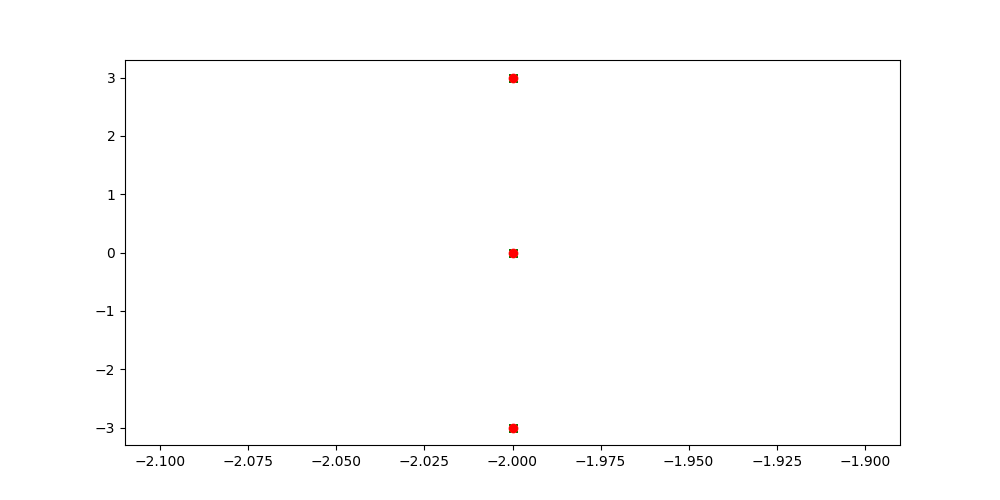

In [46]:
# another approach to plot
real_part = real_vector(poles)
imag_part = imag_vector(poles)

# Display a window with a plot of real, imag
plt.plot(real_part, imag_part, 'b-')
plt.plot(real_vector(poles), imag_vector(poles), 'gx')
plt.plot(real_part[0], imag_part[0], 'r.')
plt.plot(real_part[-1], imag_part[-1], 'ro')

plt.show()

In [47]:
#plt.rcParams['figure.figsize'] = [15, 7]
#import mpld3
#mpld3.enable_notebook()

def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

def every_nth(arr, n):
    return [range(0, len(arr))[::n], arr[::n]]


<IPython.core.display.Javascript object>


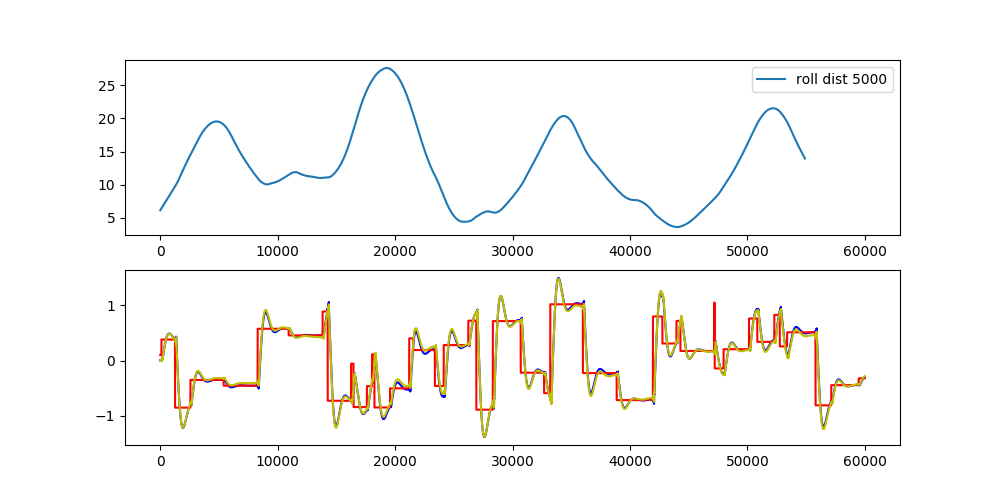

In [53]:
ax1 = plt.subplot(2, 1, 1)

#ax1.plot(*every_nth(nor0, 100), label="trace")
#ax1.plot(*every_nth(nor1, 100), label="frobenius")
#ax1.plot(*every_nth(nor2, 100), label="inf norm")
#ax1.plot(*every_nth(nor3, 100), label="1 norm")
#ax1.plot(*every_nth(nor4, 100), label="2 norm")

#ax1.plot(*every_nth(0.1*np.sum(rolling_window(np.abs(np.array(y)-np.array(y_e)), 2000), -1), 100), label="roll dist 2000")
roll_dist_5000 = 0.1*np.sum(rolling_window(np.abs(np.array(y)-np.array(y_e)), 5000), -1)
ax1.plot(*every_nth(roll_dist_5000, 100), label="roll dist 5000")

mux_5000 = nor1[0:len(roll_dist_5000)] * roll_dist_5000
#ax1.plot(*every_nth(mux_5000, 100), label="mux")
#ax1.plot(*every_nth(1*np.sum(rolling_window(np.power(np.array(y)-np.array(y_e),2), 2000), -1), 100), label="roll dist^2 2000")
#ax1.plot(*every_nth(1*np.sum(rolling_window(np.power(np.array(y)-np.array(y_e),2), 5000), -1), 100), label="roll dist^2 5000")

ax1.legend()
#  H-inf Norm in mov-window
#  Entropy in mov-window
#  Highpass

ax2 = plt.subplot(2, 1, 2, sharex=ax1)

plt.plot(y, 'b', label="real y")
plt.plot(u, 'r', label="setp u")
plt.plot(y_e, 'y-', label="esti y")

plt.show()

In [49]:
ss = pc.ss(A_k, b_k.T, c_k, d_k)

#print A_k[:,:,0,0]
#print A_k.squeeze()
#print b_k
#print c_k
#print d_k

#print poles[-1]
print ss

A = [[-2.  3.  0.]
 [-3. -2.  0.]
 [ 0.  0. -2.]]

B = [[0.15692194]
 [0.67711229]
 [0.8155904 ]]

C = [[0.27931476 0.12238792 0.56261889]]

D = [[0.01353425]]



In [50]:
print pc.dcgain(ss2)
print ss2.pole()
print ss2.zero()
print pc.dcgain(ss)
print ss.pole()
print ss.zero()

1.0
[-2.+4.j -2.-4.j]
[-6.]
0.301672782094264
[-2.+3.j -2.-3.j -2.+0.j]
[-44.33356214+0.        j  -2.46602498+2.64400091j
  -2.46602498-2.64400091j]


<IPython.core.display.Javascript object>


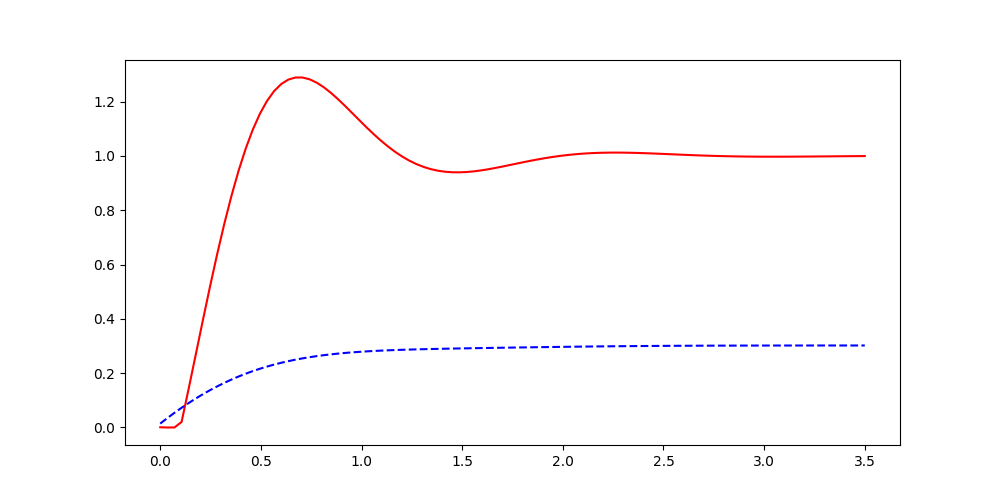

In [51]:
yout3, T3 = pc.step_response(ss3)
plt.plot(yout3, T3, 'r')
#plt.show()

yout4, T4 = pc.step_response(ss)
plt.plot(yout4, T4, 'b--')

plt.show()